In [14]:
import tensorflow as tf
import os
import numpy as np
import cv2
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D,Conv2DTranspose, concatenate
from keras.layers import LeakyReLU, Dropout, Embedding, Concatenate, BatchNormalization, ReLU, Activation
from keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from PIL import Image
import imageio
from skimage import img_as_ubyte, io
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline 

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!unzip -uq "/content/mparticles.zip" -d "/content/"

In [4]:
!pip install split-folders

In [5]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/mparticles", output="/content/mparticles-split", seed=1337, ratio=(.7, .15, .15), group_prefix=None) # default values

Copying files: 3707 files [00:00, 9818.97 files/s]


In [6]:
categories = ['CS', 'MC', 'SS']
data_directory = '/content/mparticles-split/train/'

training_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(data_directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array, (48,48))
                training_data.append([resized_array, class_num])
            except Exception as e:
                pass

In [7]:
create_training_data()
print(len(training_data))

2593


In [8]:
import random
random.shuffle(training_data)

x_train = []
y_train = []

for features, label in training_data:
    x_train.append(features)
    y_train.append(label)
    
    
x_train = np.array(x_train).reshape(-1, 48, 48, 1)
y_train = np.array(y_train).reshape(-1)

x_train = x_train/255
x_train = x_train.reshape(-1, 48, 48, 1) * 2. - 1.

#y_train = tensorflow.keras.utils.to_categorical(y_train)

2


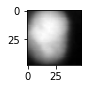

In [9]:
print(y_train[30])
plt.figure(figsize = (8,1))
plt.imshow(x_train[30].reshape(48,48), cmap='gray')
plt.show()

In [22]:
input_shape = (48,48,1)
classes = 3
latent_dim = 100
latent_code = 4
concatenated_input = latent_dim + latent_code

def build_discriminator():
    init = RandomNormal(mean=0.0, stddev=0.02)

    input_label = Input(shape=(1,)) 
    emb = Embedding(classes,40)(input_label)
    upsample = Dense(48*48*1)(emb)
    upsample = Reshape((48,48,1))(upsample)
    
    input_image = Input(shape=(48,48,1))

    concat = Concatenate()([input_image, upsample])

    h = Conv2D(64, kernel_size = (3,3), strides=2, padding='same', kernel_initializer=init)(concat)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.4)(h)

    h = Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer=init)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.4)(h)
    
    h0 = Conv2D(128, kernel_size = (3,3), strides=2, padding='same', kernel_initializer=init)(h)
    h0 = LeakyReLU(alpha=0.2)(h0)
    h0 = Dropout(0.4)(h0)
    
    h1 = Conv2D(128, kernel_size = (3,3), padding='same', kernel_initializer=init)(h0)
    h1 = LeakyReLU(alpha=0.2)(h1)
    h1 = Dropout(0.4)(h1)
    
    h2 = Conv2D(256, kernel_size = (3,3), strides=2, padding='same', kernel_initializer=init)(h1)
    h2 = LeakyReLU(alpha=0.2)(h2)
    h2 = Dropout(0.4)(h2)
    
    flat = Flatten()(h2)
    output = Dense(1, activation='sigmoid')(flat)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator = Model(inputs=[input_image, input_label], outputs=output)
    discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])    

    aux = Dense(128)(flat)
    aux = LeakyReLU(alpha=0.2)(aux)
    output2 = Dense(latent_code, activation='softmax')(aux)
   
    auxiliary = Model(inputs=[input_image, input_label], outputs=output2)
   
    return discriminator, auxiliary

In [33]:
def build_generator():
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    input_label = Input(shape=(1,))
    emb = Embedding(classes, 40)(input_label)
    emb = Dense(6*6*1)(emb)
    emb = Reshape((6, 6, 1))(emb)

    input_latent = Input(shape=(concatenated_input,))
    gen = Dense(256 * 6 * 6 )(input_latent)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((6,6, 256))(gen)

    merge = Concatenate()([gen, emb])

    gen = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer = init)(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer = init)(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    out_layer = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', activation='tanh', kernel_initializer = init)(gen)
    
    model = Model([input_latent, input_label], out_layer)
    return model

In [34]:
def build_gan(generator, discriminator, auxiliary):
    discriminator.trainable = False
    generator_latent, generator_label = generator.input
    discriminator_output = discriminator([generator.output, generator_label])
    auxiliary_output = auxiliary([generator.output, generator_label])

    gan = Model([generator_latent, generator_label], [discriminator_output, auxiliary_output])
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return gan

In [36]:
def plot_loss_history(d1, d2, g):
    fig = plt.figure(figsize=(10,6))
    # plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(d1, 'r', label='d_loss_real')
    plt.plot(d2, 'c', label='d_loss_fake')
    plt.plot(g, 'y', label='g_loss')
    plt.legend(loc='lower left', bbox_to_anchor=(0.82, 0.8), fancybox=True, shadow=True, ncol=1)
    plt.savefig('/content/infogan_logs/infogan_loss_history.png')
    plt.close()
    
def plot_acc_history(a1, a2):
    fig = plt.figure(figsize=(10,6))
    # plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100)
    plt.plot(a1, 'r', label='acc_real')     
    plt.plot(a2, 'c', label='acc_fake')
    plt.legend(loc='lower left', bbox_to_anchor=(0.82, 0.04), fancybox=True, shadow=False, ncol=1)
    plt.savefig('/content/infogan_logs/infogan_acc_history.png')
    plt.close()
    
def plot_total_loss(d, g):
    fig = plt.figure(figsize=(10,6))
    # plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(d, 'r', label='d_loss')
    plt.plot(g, 'y', label='g_loss')
    plt.legend(loc='lower left', bbox_to_anchor=(0.82, 0.8), fancybox=True, shadow=True, ncol=1)
    plt.savefig('/content/infogan_logs/infogan_total_loss.png')
    plt.close()


def plot_A_loss(d):
    fig = plt.figure(figsize=(10,6))
    # plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(d, 'r', label='Auxiliary_loss')
    plt.legend(loc='lower left', bbox_to_anchor=(0.82, 0.8), fancybox=True, shadow=True, ncol=1)
    plt.savefig('/content/infogan_logs/infogan_A_loss.png')
    plt.close()

In [ ]:
discriminator, auxiliary = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator, auxiliary)

auxiliary.summary()

In [ ]:
epochs=10000
batch_size=64

d = list()
d1 = list()
d2 = list()
g  = list() 
a1 = list() 
a2 = list()
da = list()
ga = list()
aux = list()

def generate_latent_variables(latent_dim, samples, latent_code, classes=3):
    x = np.random.randn(latent_dim * samples)
    x = x.reshape(samples, latent_dim)
    label = np.random.randint(0, classes, samples)
    category = np.random.randint(0, latent_code, samples)
    category = to_categorical(category, num_classes=latent_code)
    z = np.hstack((x, category))
    return [z, category, label]
 
def fake_samples(generator, latent_dim, samples):
    z, category, label = generate_latent_variables(latent_dim, samples, latent_code)
    images = generator.predict([z, label])
    y = np.zeros((samples, 1))
    return [images, label], y

def real_samples(x_train, samples):
    random_samples = np.random.randint(0, x_train.shape[0], samples)
    x, label = x_train[random_samples], y_train[random_samples]
    y = np.ones((samples, 1))
    return [x, label], y

    
for i in range(epochs):
    for j in range(58):
                
        [x_real, real_labels], y_real = real_samples(x_train, batch_size//2)
        d_loss_real, d_acc_real = discriminator.train_on_batch([x_real, real_labels], y_real)
            
        [x_fake, fake_labels], y_fake = fake_samples(generator, latent_dim, batch_size//2)
        d_loss_fake, d_acc_fake = discriminator.train_on_batch([x_fake, fake_labels], y_fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_acc = 0.5 * np.add(d_acc_real, d_acc_fake)
            
        z, category, label = generate_latent_variables(latent_dim, batch_size, latent_code)
        y_gan = np.ones((batch_size, 1))
                    
        g_0, g_1, g_2 = gan.train_on_batch([z, label], [y_gan, category])
        
    d.append(d_loss)
    d1.append(d_loss_real)
    d2.append(d_loss_fake)
    g.append(g_1)
    a1.append(d_acc_real*100)
    a2.append(d_acc_fake*100)
    da.append(d_acc*100)
    aux.append(g_2)
    
    if (i%200 == 0):
        generator.save(f'/content/infogan_logs/infogan-particles-{i}.h5')
        plot_loss_history(d1, d2, g)
        plot_acc_history(a1, a2)
        plot_total_loss(d, g)
        plot_A_loss(aux)
            
    print(f'Epoch: {i+1}:  D_loss_r: {d_loss_real} -  D_loss_f: {d_loss_fake} - G_loss: {g_1} - A_loss: {g_2}')
    
    
plot_loss_history(d1, d2, g)
plot_acc_history(a1, a2)
plot_total_loss(d, g)
plot_A_loss(aux)
   

In [60]:
def generate_latent_variables(latent_dim, samples, latent_code=4):
    x = np.random.randn(latent_dim * samples)
    x = x.reshape(samples, latent_dim)
    labels = np.asarray([x for _ in range(10) for x in range(0,1)])
    category = np.random.randint(0, latent_code, samples)
    category = to_categorical(category, latent_code)
    z = np.hstack((x, category))
    return [z, category, labels]

z_input, category, labels = generate_latent_variables(100, 10)
images  = generator.predict([z_input, labels])
images = (images+1)/2 * 255

In [ ]:
i=0
for image in images:
    plt.figure(figsize = (10,1))
    i+=1
    # plt.imshow(image.reshape(48,48), cmap='gray')
    # plt.show()
    img_name = f'generated-infogan-{i}.png'
    imageio.imwrite('/content/imgs/'+img_name, image)